# Task 2: Experimentation and uplift testing

#

<font size="3"> **Background information**
    
<font size="3"> You are part of Quantium’s retail analytics team and have been approached by your client, the Category Manager for Chips, has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.
    
<font size="3"> **Task**
    
<font size="3"> Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

<font size="3"> To get started use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store.
    
<font size="3"> This can be broken down by:
- <font size="3"> total sales revenue
- <font size="3"> total number of customers
- <font size="3"> average number of transactions per customer

<font size="3"> Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.
<font size="3"> Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

In [ ]:
# load packages
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import re
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


<font size="4"> Load the data on transactions.

In [ ]:
# load data
transaction = pd.read_excel('/content/QVI_transaction_data (2).xlsx')
# make columns's names more interpretable
transaction = transaction.rename(columns={'STORE_NBR':'Store_number', 'LYLTY_CARD_NBR':'Card_number', 'TXN_ID':'Transaction_id',
                                          'PROD_NBR':'Product_number', 'PROD_NAME':'Product_name', 'PROD_QTY':'Product_quantity', 'TOT_SALES':'Total_sales'})
transaction.head(5)   #

,DATE,Store_number,Card_number,Transaction_id,Product_number,Product_name,Product_quantity,Total_sales
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


- <font size="3"> period before trial : 07/2018 to 02/2019 (8 months)
- <font size="3"> trial period: 03/2019 to 06/2019 (4 months)

<font size="3"> This task can be finished in 2 steps:
- <font size="3"> Step 1: Based on the first 8 months' data, find the control store of each trial store (the control store is actually the store that displays very similar trend and pattern to the trial store)
- <font size="3"> Step 2: Compare the last 4 months' data to identify the impact of the new trial layouts

### Step 1: find the control store  
<font size="3"> In order to find the control store, we need to calculate the similarity between each store and a trial store first. The store with the highest similarity is chosen as the control store.  
<font size="3"> I pick monthly sales revenue and monthly customers count as the key metrics to measure the overall similarity.

In [ ]:
#
store_trial = [77,86,88]
all_store = full['Store_number'].unique().tolist()
all_months = full['Date'].unique().tolist()

In [ ]:
#
store_months = []
for i in all_store:
    for j in all_months:
        store_months.append([i, j])
store_months = pd.DataFrame(data=store_months, columns=['Store_number', 'Date'])
store_months.head(1)

,Store_number,Date
0,116,2018-07


In [ ]:
# monthly sales revenue.
monthly_total_sales = full.groupby(['Store_number', 'Date'])['Total_sales'].sum().reset_index(name='sales_revenue')
store_months = store_months.merge(monthly_total_sales, on=['Store_number', 'Date'], how='left')
store_months['sales_revenue'].fillna(0, inplace=True)    # missing value means mean no sales revenue, so replace with 0
store_months.head(1)

,Store_number,Date,sales_revenue
0,116,2018-07,824.8


In [ ]:
# monthly number of customers
monthly_total_customer = full[['Store_number', 'Date','Card_number']].drop_duplicates().groupby(['Store_number', 'Date']).size().reset_index(name='customer_count')
store_months = store_months.merge(monthly_total_customer, on=['Store_number', 'Date'], how='left')
store_months['customer_count'].fillna(0, inplace=True)     # missing value means no customer, so replace with 0
store_months.head(1)

,Store_number,Date,sales_revenue,customer_count
0,116,2018-07,824.8,90.0


In [ ]:
# monthly number of transactions
monthly_transactions = full[['Store_number', 'Date','Transaction_id']].drop_duplicates().groupby(['Store_number', 'Date']).size().reset_index(name='transactions_count')
store_months = store_months.merge(monthly_transactions, on=['Store_number', 'Date'], how='left')
store_months['transactions_count'].fillna(0, inplace=True)     # missing value means no transaction, so replace with 0
store_months.head(1)

,Store_number,Date,sales_revenue,customer_count,transactions_count
0,116,2018-07,824.8,90.0,118.0


In [ ]:
# monthly sales volume
monthly_quantity = full.groupby(['Store_number', 'Date'])['Product_quantity'].sum().reset_index(name='sales_volume')
store_months = store_months.merge(monthly_quantity, on=['Store_number', 'Date'], how='left')
store_months['sales_volume'].fillna(0, inplace=True)
store_months.head(1)

,Store_number,Date,sales_revenue,customer_count,transactions_count,sales_volume
0,116,2018-07,824.8,90.0,118.0,236.0


<font size="3"> First, calculate the correlation coefficient to evalute the linear correlation between two stores.
- <font size="3"> A higher correlation coefficient indicates the two store are positively correlated. In other words, the two stores have very similar trend and patterns.
- <font size="3"> A lower correlation coefficient indicates the two store are nagetively correlated. In other words, the two stores have very similar trend and patterns, but in the opposite directions.
- <font size="3"> A zero correlation coefficient indicates the two store are completely not correlated at all. There is no relationship between the two stores.  
    
<font size="3"> Clearly, the store with the highest correlation coefficient is what we look for.

In [ ]:
# define a function to calculate the correlation coefficient of a specific attribute between trial store and all other stores
def cal_correlation_coeff(dataset, target_attribute, trial_store):
    other_stores = [i for i in all_store if i not in store_trial]      # excluding 3 trail stores
    trial_months = [i for i in all_months if pd.to_datetime(i) <= pd.to_datetime('2019-02-01')]     # the first 8 months
    trial_store_data = dataset[(dataset['Store_number']==trial_store)&(dataset['Date'].isin(trial_months))][target_attribute].tolist()  # extract data of trial store
    store_corr = []
    for store in other_stores:    # loop throughout all stores excluding the trial store
        another_store_data = dataset[(dataset['Store_number']==store)&(dataset['Date'].isin(trial_months))][target_attribute].tolist()
        corr_ = pd.DataFrame({'trial_shop':trial_store_data, 'another_store':another_store_data}).corr()['another_store'][0]  # calculate correlation coefficient
        store_corr.append([trial_store, store, corr_])
    trial_store_sales_corr_df = pd.DataFrame(data=store_corr, columns=['trial_store', 'another_store', f"{target_attribute}_corr"])
    trial_store_sales_corr_df.fillna(0, inplace=True)   # replace missing values with 0
    return trial_store_sales_corr_df

<font size="3"> Then, calculate the difference in key metrics between two stores. Note: need to normalize the differences in order to enable the differences to be used to measure the similarity along with the correlation coefficient.
- <font size="3"> A higher difference indicates values of a metric of two stores are quite different.
- <font size="3"> A lower difference indicates values of a metric of two stores are quite close.

<font size="3"> **Note: There is no necessary relationship between the difference and the correlation coefficient.**

In [ ]:
# define a function to calculate difference of a specific attribute between trial store and all other stores
def cal_difference(dataset, target_attribute, trial_store):
    other_stores = [i for i in all_store if i not in store_trial]      # excluding 3 trail stores
    trial_months = [i for i in all_months if pd.to_datetime(i) <= pd.to_datetime('2019-02-01')]     # the first 8 months
    trial_store_data = dataset[(dataset['Store_number']==trial_store)&(dataset['Date'].isin(trial_months))][target_attribute].tolist()  # extract data of trial store
    data_df = pd.DataFrame(columns=['Date', 'trial_store', 'another_store', 'target', 'another'])
    for store in other_stores:     # loop throughout all stores excluding the trial store
        another_store_data = dataset[(dataset['Store_number']==store)&(dataset['Date'].isin(trial_months))][target_attribute].tolist()
        diff_df = pd.DataFrame({'Date':trial_months,
                                'trial_store':[trial_store]*len(trial_months),
                                'another_store':[store]*len(trial_months),
                                'target':trial_store_data,
                                'another':another_store_data})
        data_df = pd.concat([data_df, diff_df], axis=0, ignore_index=True)
    data_df['absolute_diff'] = np.abs(data_df['target'] - data_df['another'])
    data_df = data_df.merge(data_df.groupby(['Date']).agg([np.max, np.min])['absolute_diff'].reset_index(), on=['Date'], how='left')
    # normalize the differences, make the value in the range between 0 and 1
    data_df['diff_magnitude'] = 1 - (data_df['absolute_diff'] - data_df['amin'])/(data_df['amax'] - data_df['amin'])
    avg_diff = data_df.groupby(['trial_store', 'another_store'])['diff_magnitude'].mean().reset_index(name=f"{target_attribute}_avg_diff_magnitude")
    return avg_diff

<font size="3"> Let's find out which store is the control store of the trial store 77.

In [ ]:
#
trial_store = 77
# key metrics
metric_1 = 'sales_revenue'
metric_2 = 'customer_count'
# correlation coefficient
metric_1_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)
# difference
metric_1_diff = cal_difference(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_diff = cal_difference(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)

<font size="3"> It's clear that the store 233 is the control store (most similar store) of the trial store 77.

In [ ]:
#
store_score = metric_1_corr.merge(metric_2_corr, on=['trial_store','another_store'])
store_score = store_score.merge(metric_1_diff, on=['trial_store','another_store'])
store_score = store_score.merge(metric_2_diff, on=['trial_store','another_store'])
#
store_score['avg_diff'] = store_score[[f'{metric_1}_avg_diff_magnitude', f'{metric_2}_avg_diff_magnitude']].mean(axis=1)
store_score['avg_score'] = store_score[store_score.columns[2:]].mean(axis=1)
store_score.sort_values(by=['avg_score'], ascending=False).head()    # top 5 store with the highest similarity.

,trial_store,another_store,sales_revenue_corr,customer_count_corr,sales_revenue_avg_diff_magnitude,customer_count_avg_diff_magnitude,avg_diff,avg_score
98,77,233,0.963602,0.968535,0.987485,0.982307,0.984896,0.977365
220,77,41,0.553435,0.836286,0.964095,0.971600,0.967848,0.858653
127,77,17,0.734715,0.661942,0.889267,0.966167,0.927717,0.835962
212,77,254,0.652782,0.765944,0.914533,0.904528,0.909530,0.829463
100,77,115,0.727633,0.574411,0.934943,0.959098,0.947020,0.828621


<font size="3"> We can clearly see, in the trial period, two stores display very different trend and pattern.

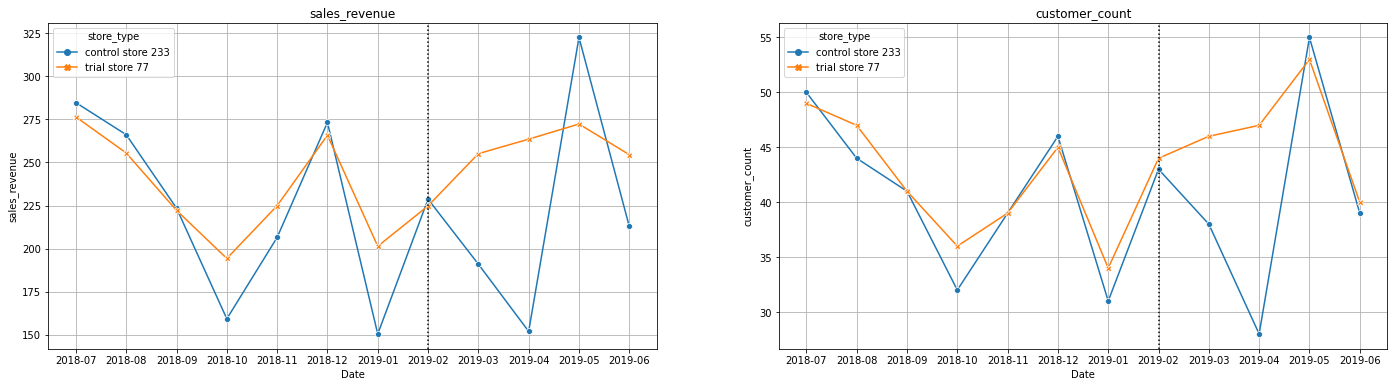

In [ ]:
#
fig = plt.figure(figsize=(24,6))
# Sales revenue
fig.add_subplot(1, 2, 1)
sns.lineplot(data=trial_control_data, x='Date', y=metric_1, hue='store_type', markers=True, style="store_type", dashes=False)
plt.axvline('2019-02', color='black', linestyle='dotted')
plt.grid()
plt.title(metric_1)
# Number of customers
fig.add_subplot(1, 2, 2)
sns.lineplot(data=trial_control_data, x='Date', y=metric_2, hue='store_type', markers=True, style="store_type", dashes=False)
plt.axvline('2019-02', color='black', linestyle='dotted')
plt.grid()
plt.title(metric_2)
plt.show()

<font size="3"> Let's calculate the difference in key metrics between two stores. The ratio of differnece to metric value of control store can display clearer patterns.

In [ ]:
trial_control_diff = control_data[['Date']].copy()
trial_control_diff['Date'] = pd.to_datetime(trial_control_diff['Date'])
trial_control_diff[f'{metric_1}_diff'] = trial_data[metric_1] - control_data[metric_1]
trial_control_diff[f'{metric_2}_diff'] = trial_data[metric_2] - control_data[metric_2]
trial_control_diff[f'{metric_1}_diff_percent'] = trial_control_diff[f'{metric_1}_diff']/control_data[metric_1]
trial_control_diff[f'{metric_2}_diff_percent'] = trial_control_diff[f'{metric_2}_diff']/control_data[metric_2]
trial_control_diff

,Date,sales_revenue_diff,customer_count_diff,sales_revenue_diff_percent,customer_count_diff_percent
0,2018-07-01,-8.3,-1.0,-0.029153,-0.020000
1,2018-08-01,-10.6,3.0,-0.039835,0.068182
2,2018-09-01,-1.3,0.0,-0.005817,0.000000
3,2018-10-01,35.0,4.0,0.219711,0.125000
4,2018-11-01,18.4,0.0,0.089104,0.000000
5,2018-12-01,-7.4,-1.0,-0.027086,-0.021739
6,2019-01-01,50.9,3.0,0.338206,0.096774
7,2019-02-01,-3.9,1.0,-0.017053,0.023256
8,2019-03-01,64.1,8.0,0.335602,0.210526
9,2019-04-01,111.5,19.0,0.733553,0.678571


- <font size="3"> **Sales revenue**
    - <font size="3"> **The new trial layouts had a significant, positive impact on sales revenue (increase by up to 73%) in April.**
    - <font size="3"> **As the maximum difference in sales revenue during the period before trial reached 34%, the difference in March might not be caused by the new trial layouts.**
    - <font size="3"> **The new trial layouts seemed to have a positive impact in June and a nagetive impact in May.**
- <font size="3"> **Number of customers**
    - <font size="3"> **The new trial layouts had a significant, positive impact on the number of customers (increase by up to 68%) in April.**
    - <font size="3"> **As the maximum difference in the number of customers during the period before trial reached 12%, the difference in March might not completely be caused by the new trial layouts.**
    - <font size="3"> **The new trial layouts had a weak impact in May and June.**

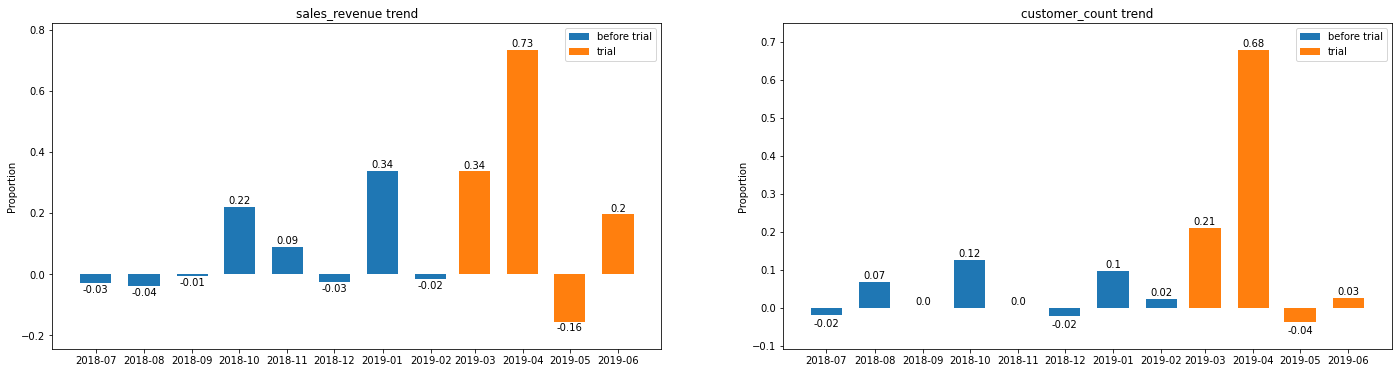

In [ ]:
#
fig, ax = plt.subplots(1, 2, figsize=(24,6))
#
ax[0].bar(trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')][f'{metric_1}_diff_percent'],
          width=20, label='before trial')
ax[0].bar(trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')][f'{metric_1}_diff_percent'],
          width=20, label='trial')
add_value_to_barchart(ax=ax[0], gap_between_value_bar=0.01)
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].set_title(f'{metric_1} trend')
ax[0].legend()
ax[0].set_ylabel('Proportion')
#
ax[1].bar(trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')][f'{metric_2}_diff_percent'],
          width=20, label='before trial')
ax[1].bar(trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')][f'{metric_2}_diff_percent'],
          width=20, label='trial')
add_value_to_barchart(ax=ax[1], gap_between_value_bar=0.01)
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].set_title(f'{metric_2} trend')
ax[1].legend()
ax[1].set_ylabel('Proportion')
plt.show()

<font size="3"> Let's find out which store is the control store of the trial store 86.

In [ ]:
#
trial_store = 86
# key metrics
metric_1 = 'sales_revenue'
metric_2 = 'customer_count'
# correlation coefficient
metric_1_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)
# difference
metric_1_diff = cal_difference(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_diff = cal_difference(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)

<font size="3"> We can see the store 155 is the control store (most similar store) of the trial store 86.

In [ ]:
#
store_score = metric_1_corr.merge(metric_2_corr, on=['trial_store','another_store'])
store_score = store_score.merge(metric_1_diff, on=['trial_store','another_store'])
store_score = store_score.merge(metric_2_diff, on=['trial_store','another_store'])
#
store_score['avg_diff'] = store_score[[f'{metric_1}_avg_diff_magnitude', f'{metric_2}_avg_diff_magnitude']].mean(axis=1)
store_score['avg_score'] = store_score[store_score.columns[2:]].mean(axis=1)
store_score.sort_values(by=['avg_score'], ascending=False).head()    # top 5 store with the highest similarity.

,trial_store,another_store,sales_revenue_corr,customer_count_corr,sales_revenue_avg_diff_magnitude,customer_count_avg_diff_magnitude,avg_diff,avg_score
85,86,155,0.811905,0.486872,0.960952,0.954473,0.957713,0.834383
126,86,147,0.683127,0.594304,0.920498,0.908710,0.914604,0.804249
45,86,229,0.546859,0.638922,0.931674,0.950029,0.940852,0.801667
131,86,172,0.646093,0.363517,0.942445,0.926415,0.934430,0.762580
8,86,231,0.721680,0.442559,0.795727,0.931624,0.863675,0.751053


<font size="3"> Compare the key metrics between trial store and control store.

In [ ]:
# the store with the highest similarity
control_store = store_score.sort_values(by=['avg_score'], ascending=False)['another_store'].values[0]
#
control_data = store_months[store_months['Store_number']==control_store].reset_index(drop=True)
control_data['store_type'] = f'control store {control_store}'
trial_data = store_months[store_months['Store_number']==trial_store].reset_index(drop=True)
trial_data['store_type'] = f'trial store {trial_store}'
#
trial_control_data = pd.concat([control_data, trial_data], ignore_index=True)
trial_control_data.head()

,Store_number,Date,sales_revenue,customer_count,transactions_count,sales_volume,store_type
0,155,2018-07,921.6,100.0,122.0,248.0,control store 155
1,155,2018-08,762.3,89.0,116.0,225.0,control store 155
2,155,2018-09,965.8,98.0,135.0,272.0,control store 155
3,155,2018-10,940.4,106.0,133.0,266.0,control store 155
4,155,2018-11,856.2,100.0,126.0,256.0,control store 155


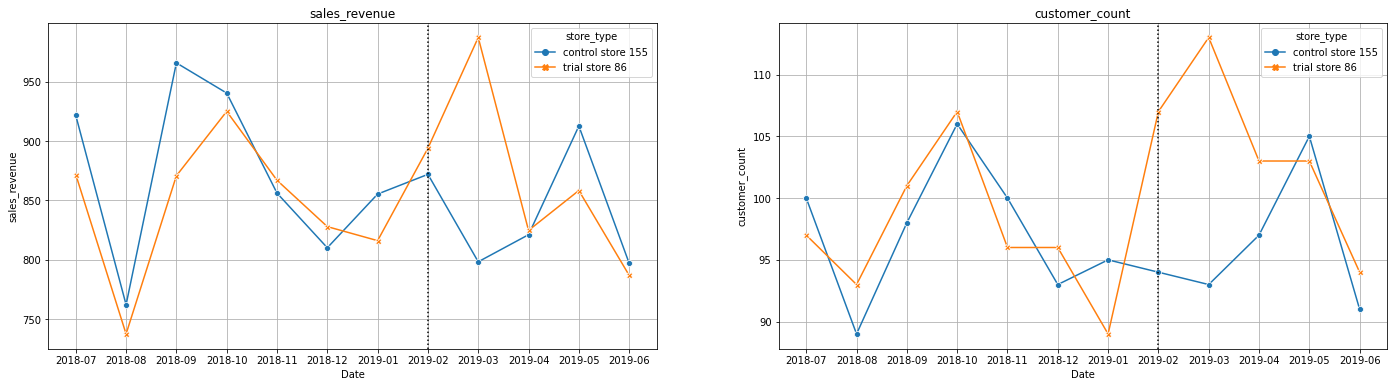

In [ ]:
#
fig = plt.figure(figsize=(24,6))
# Sales revenue
fig.add_subplot(1, 2, 1)
sns.lineplot(data=trial_control_data, x='Date', y=metric_1, hue='store_type', markers=True, style="store_type", dashes=False)
plt.axvline('2019-02', color='black', linestyle='dotted')
plt.grid()
plt.title(metric_1)
# Number of customers
fig.add_subplot(1, 2, 2)
sns.lineplot(data=trial_control_data, x='Date', y=metric_2, hue='store_type', markers=True, style="store_type", dashes=False)
plt.axvline('2019-02', color='black', linestyle='dotted')
plt.grid()
plt.title(metric_2)
plt.show()

<font size="3"> Let's calculate the difference in key metrics between two stores. The ratio of differnece to metric value of control store can display clearer patterns.

- <font size="3"> **Sales revenue**
    - <font size="3"> **The new trial layouts had a significant, positive impact on sales revenue (increase by up to 24%) in March and had a weak impact in the remaining 3 months.**
- <font size="3"> **Number of customers**
    - <font size="3"> **As the maximum difference in number of customers during the period before trial reached 14%, the difference in March might not completely be caused by the new trial layouts. So, the new trial layouts seemed to have a positive impact on number of customers in March.**
    - <font size="3"> **During the remaining 3 months, the new trial layouts had a weak impact on the number of customers.**

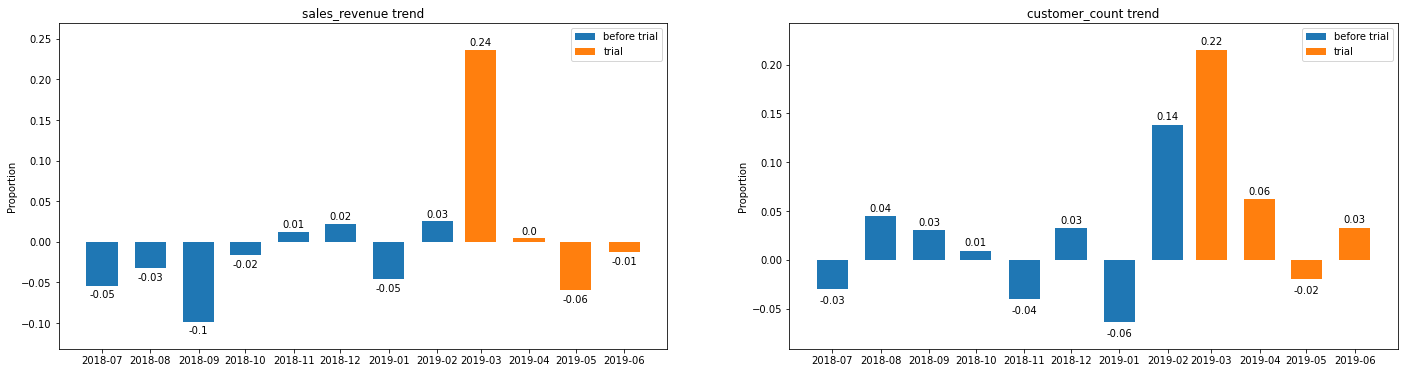

In [ ]:
#
fig, ax = plt.subplots(1, 2, figsize=(24,6))
#
ax[0].bar(trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')][f'{metric_1}_diff_percent'],
          width=20, label='before trial')
ax[0].bar(trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')][f'{metric_1}_diff_percent'],
          width=20, label='trial')
add_value_to_barchart(ax=ax[0], gap_between_value_bar=0.005)
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].set_title(f'{metric_1} trend')
ax[0].legend()
ax[0].set_ylabel('Proportion')
#
ax[1].bar(trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')][f'{metric_2}_diff_percent'],
          width=20, label='before trial')
ax[1].bar(trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')][f'{metric_2}_diff_percent'],
          width=20, label='trial')
add_value_to_barchart(ax=ax[1], gap_between_value_bar=0.005)
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].set_title(f'{metric_2} trend')
ax[1].legend()
ax[1].set_ylabel('Proportion')
plt.show()

<font size="3"> Let's find out which store is the control store of the trial store 88.

In [ ]:
#
trial_store = 88
# key metrics
metric_1 = 'sales_revenue'
metric_2 = 'customer_count'
# correlation coefficient
metric_1_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_corr = cal_correlation_coeff(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)
# difference
metric_1_diff = cal_difference(dataset=store_months, target_attribute=metric_1, trial_store=trial_store)
metric_2_diff = cal_difference(dataset=store_months, target_attribute=metric_2, trial_store=trial_store)

<font size="3"> It's clear that the store 237 is the control store (most similar store) of the trial store 88.

In [ ]:
#
store_score = metric_1_corr.merge(metric_2_corr, on=['trial_store','another_store'])
store_score = store_score.merge(metric_1_diff, on=['trial_store','another_store'])
store_score = store_score.merge(metric_2_diff, on=['trial_store','another_store'])
store_score['avg_score'] = store_score[store_score.columns[2:]].mean(axis=1)
store_score.sort_values(by=['avg_score'], ascending=False).head()    # top 5 store with the highest similarity.

,trial_store,another_store,sales_revenue_corr,customer_count_corr,sales_revenue_avg_diff_magnitude,customer_count_avg_diff_magnitude,avg_score
20,88,237,0.176471,0.927483,0.955669,0.984446,0.761017
161,88,178,0.526331,0.900220,0.723785,0.835695,0.746508
54,88,123,0.393619,0.663886,0.856554,0.894801,0.702215
183,88,7,0.632237,0.279788,0.785334,0.835157,0.633129
181,88,69,0.185123,0.647882,0.719565,0.869765,0.605584


<font size="3"> Compare the key metrics between trial store and control store.

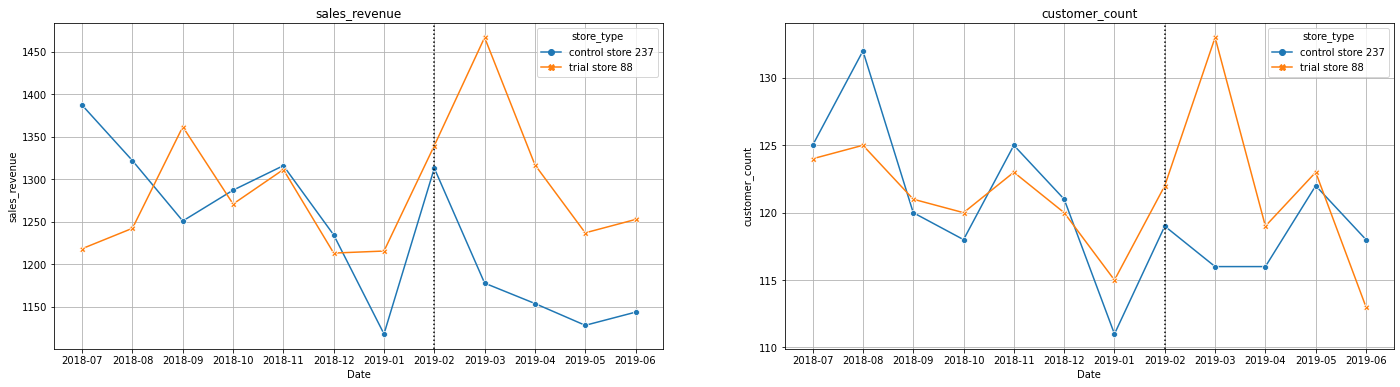

In [ ]:
#
fig = plt.figure(figsize=(24,6))
# Sales revenue
fig.add_subplot(1, 2, 1)
sns.lineplot(data=trial_control_data, x='Date', y=metric_1, hue='store_type', markers=True, style="store_type", dashes=False)
plt.axvline('2019-02', color='black', linestyle='dotted')
plt.grid()
plt.title(metric_1)
# Number of customers
fig.add_subplot(1, 2, 2)
sns.lineplot(data=trial_control_data, x='Date', y=metric_2, hue='store_type', markers=True, style="store_type", dashes=False)
plt.axvline('2019-02', color='black', linestyle='dotted')
plt.grid()
plt.title(metric_2)
plt.show()

<font size="3"> Let's calculate the difference in key metrics between two stores. The ratio of differnece to metric value of control store can display clearer patterns.

In [ ]:
trial_control_diff = control_data[['Date']].copy()
trial_control_diff['Date'] = pd.to_datetime(trial_control_diff['Date'])
trial_control_diff[f'{metric_1}_diff'] = trial_data[metric_1] - control_data[metric_1]
trial_control_diff[f'{metric_2}_diff'] = trial_data[metric_2] - control_data[metric_2]
trial_control_diff[f'{metric_1}_diff_percent'] = trial_control_diff[f'{metric_1}_diff']/control_data[metric_1]
trial_control_diff[f'{metric_2}_diff_percent'] = trial_control_diff[f'{metric_2}_diff']/control_data[metric_2]
trial_control_diff

,Date,sales_revenue_diff,customer_count_diff,sales_revenue_diff_percent,customer_count_diff_percent
0,2018-07-01,-169.00,-1.0,-0.121828,-0.008000
1,2018-08-01,-79.70,-7.0,-0.060292,-0.053030
2,2018-09-01,111.00,1.0,0.088743,0.008333
3,2018-10-01,-16.30,2.0,-0.012664,0.016949
4,2018-11-01,-4.60,-2.0,-0.003495,-0.016000
5,2018-12-01,-21.40,-1.0,-0.017336,-0.008264
6,2019-01-01,97.70,4.0,0.087412,0.036036
7,2019-02-01,26.60,3.0,0.020259,0.025210
8,2019-03-01,289.40,17.0,0.245754,0.146552
9,2019-04-01,163.40,3.0,0.141644,0.025862


- <font size="3"> **Sales revenue**
    - <font size="3"> **The new trial layouts had a significant, positive impact on sales revenue (increase by up to 25%) in March.**
    - <font size="3"> **The new trial layouts seemed to have a positive impact in the remaining 3 months.**
- <font size="3"> **Number of customers**
    - <font size="3"> **The new trial layouts had a significant, positive impact on the number of customers (increase by up to 15%) in March.**
    - <font size="3"> **The new trial layouts seemed to have a positive impact in April**
    - <font size="3"> **The new trial layouts seemed to have a weak impact in May**
    - <font size="3"> **The new trial layouts seemed to have a nagetive impact in June**

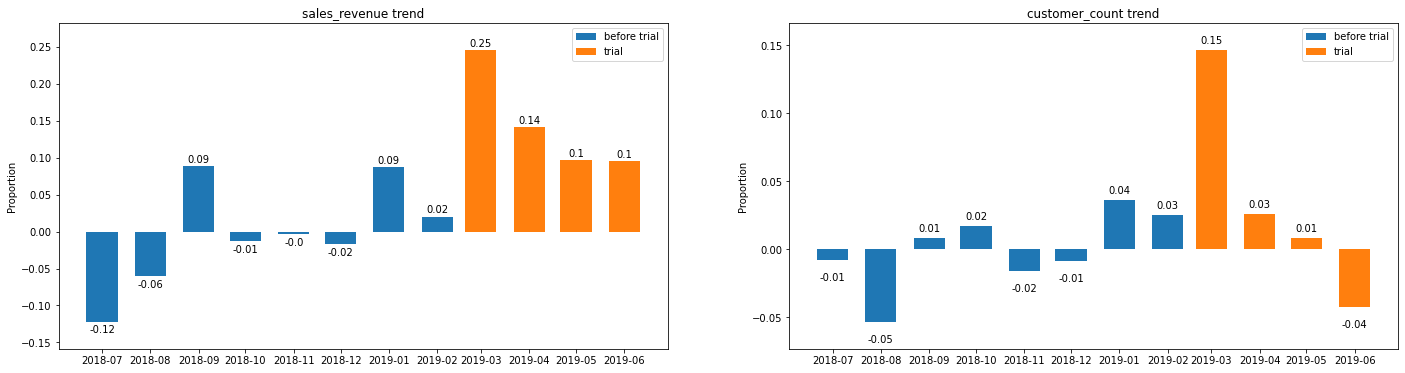

In [ ]:
#
fig, ax = plt.subplots(1, 2, figsize=(24,6))
#
ax[0].bar(trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')][f'{metric_1}_diff_percent'],
          width=20, label='before trial')
ax[0].bar(trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')][f'{metric_1}_diff_percent'],
          width=20, label='trial')
add_value_to_barchart(ax=ax[0], gap_between_value_bar=0.005)
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].set_title(f'{metric_1} trend')
ax[0].legend()
ax[0].set_ylabel('Proportion')
#
ax[1].bar(trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']<=pd.to_datetime('2019-02-01')][f'{metric_2}_diff_percent'],
          width=20, label='before trial')
ax[1].bar(trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')]['Date'],
          trial_control_diff[trial_control_diff['Date']>pd.to_datetime('2019-02-01')][f'{metric_2}_diff_percent'],
          width=20, label='trial')
add_value_to_barchart(ax=ax[1], gap_between_value_bar=0.005)
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].set_title(f'{metric_2} trend')
ax[1].legend()
ax[1].set_ylabel('Proportion')
plt.show()

<font size="3"> **Overall**
- <font size="3"> **The new trial layouts had a positive impact on sales revenue and number of customers in March and April.**
- <font size="3"> **In May and June, the new trial layouts seemed to have a weak impact.**

Conclusion:

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86. We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that
we have finished our analysis, we can prepare our presentation to the Category Manager.